In [3]:
#!pip install -r requirements.txt

  Using cached threadpoolctl-3.4.0-py3-none-any.whl.metadata (13 kB)
   ---------------------------------------- 0.0/10.6 MB ? eta -:--:--
   ---------------------------------------- 0.0/10.6 MB ? eta -:--:--
   ---------------------------------------- 0.0/10.6 MB 330.3 kB/s eta 0:00:33
   ---------------------------------------- 0.1/10.6 MB 375.8 kB/s eta 0:00:29
   ---------------------------------------- 0.1/10.6 MB 375.8 kB/s eta 0:00:29
   ---------------------------------------- 0.1/10.6 MB 375.8 kB/s eta 0:00:29
   ---------------------------------------- 0.1/10.6 MB 375.8 kB/s eta 0:00:29
   ---------------------------------------- 0.1/10.6 MB 375.8 kB/s eta 0:00:29
   ---------------------------------------- 0.1/10.6 MB 375.8 kB/s eta 0:00:29
   ---------------------------------------- 0.1/10.6 MB 375.8 kB/s eta 0:00:29
   ---------------------------------------- 0.1/10.6 MB 375.8 kB/s eta 0:00:29
   ---------------------------------------- 0.1/10.6 MB 375.8 kB/s eta 0:00:29
 

In [137]:
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.inspection import permutation_importance
from sklearn.model_selection import RandomizedSearchCV  
import warnings

In [6]:
warnings.filterwarnings("ignore")

In [7]:
pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', 500)

## Functions that I'll use in this notebook

In [121]:
from myfunctions import * 
from sklearn import metrics

def test_regression_models(X_train, y_train, X_test, y_test, models:list, metric):
    best_model = None
    best_score = float('inf') # start with infinity so that any score will be better
    for model in models:
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        score = metric(y_test, y_pred)
        if score < best_score:
            best_score = score
            best_model = model
        print("\n" + str(model) + ":\n"+str(metric)+":\n" + str(score))
    return best_model

def plot_feature_importances(model, X_columns):  
    importances = model.feature_importances_  
    indices = np.argsort(importances)[::-1]  
    plt.figure(figsize=(10, 6))  
    plt.title("Feature importances")  
    # Only plot the feature importances of the top n features  
    n_features = len(X_columns)  
    plt.bar(range(n_features), importances[indices], color="b", align="center")  
    plt.xticks(range(n_features), np.array(X_columns)[indices], rotation='vertical')  
    plt.xlim([-1, n_features])  
    plt.show()  
    
def plot_permutation_importances(X_columns, importances, X_train, indices, std):  
    plt.figure(figsize=(20, 7))
    plt.title("Feature permutation importances")
    plt.bar(range(X_train.shape[1]), importances[indices], color="r", yerr=std[indices], align="center")
    plt.xticks(range(X_train.shape[1]), [X_columns[indices[f]] for f in range(X_train.shape[1])])
    plt.xticks(rotation=70)
    plt.xlim([-1, X_train.shape[1]])
    plt.show()

## Read the dataset

In [9]:
DATASET_PATH = "../data/beer_profile_and_ratings.csv"

In [10]:
print(os.path.exists(DATASET_PATH))

True


In [11]:
#save_fraction_csv(DATASET_PATH, "dataset", "new_input.csv", 0.1)

In [12]:
ds = pd.read_csv(DATASET_PATH)

In [13]:
ds.shape

(3197, 25)

In [14]:
ds.head()

,Name,Style,Brewery,Beer Name (Full),Description,ABV,Min IBU,Max IBU,Astringency,Body,Alcohol,Bitter,Sweet,Sour,Salty,Fruits,Hoppy,Spices,Malty,review_aroma,review_appearance,review_palate,review_taste,review_overall,number_of_reviews
0,Amber,Altbier,Alaskan Brewing Co.,Alaskan Brewing Co. Alaskan Amber,"Notes:Richly malty and long on the palate, wit...",5.3,25,50,13,32,9,47,74,33,0,33,57,8,111,3.498994,3.636821,3.556338,3.643863,3.847082,497
1,Double Bag,Altbier,Long Trail Brewing Co.,Long Trail Brewing Co. Double Bag,"Notes:This malty, full-bodied double alt is al...",7.2,25,50,12,57,18,33,55,16,0,24,35,12,84,3.798337,3.846154,3.904366,4.024948,4.034304,481
2,Long Trail Ale,Altbier,Long Trail Brewing Co.,Long Trail Brewing Co. Long Trail Ale,Notes:Long Trail Ale is a full-bodied amber al...,5.0,25,50,14,37,6,42,43,11,0,10,54,4,62,3.409814,3.667109,3.600796,3.631300,3.830239,377
3,Doppelsticke,Altbier,Uerige Obergärige Hausbrauerei GmbH / Zum Uerige,Uerige Obergärige Hausbrauerei GmbH / Zum Ueri...,Notes:,8.5,25,50,13,55,31,47,101,18,1,49,40,16,119,4.148098,4.033967,4.150815,4.205163,4.005435,368
4,Sleigh'r Dark Doüble Alt Ale,Altbier,Ninkasi Brewing Company,Ninkasi Brewing Company Sleigh'r Dark Doüble A...,Notes:Called 'Dark Double Alt' on the label.Se...,7.2,25,50,25,51,26,44,45,9,1,11,51,20,95,3.625000,3.973958,3.734375,3.765625,3.817708,96


<hr>

#### Types

In [15]:
ds.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3197 entries, 0 to 3196
Data columns (total 25 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Name               3197 non-null   object 
 1   Style              3197 non-null   object 
 2   Brewery            3197 non-null   object 
 3   Beer Name (Full)   3197 non-null   object 
 4   Description        3197 non-null   object 
 5   ABV                3197 non-null   float64
 6   Min IBU            3197 non-null   int64  
 7   Max IBU            3197 non-null   int64  
 8   Astringency        3197 non-null   int64  
 9   Body               3197 non-null   int64  
 10  Alcohol            3197 non-null   int64  
 11  Bitter             3197 non-null   int64  
 12  Sweet              3197 non-null   int64  
 13  Sour               3197 non-null   int64  
 14  Salty              3197 non-null   int64  
 15  Fruits             3197 non-null   int64  
 16  Hoppy              3197 

<hr>

## Data engineering

In [16]:
print_unique(ds)

Name                 3066
Style                 111
Brewery               934
Beer Name (Full)     3197
Description          1841
ABV                   194
Min IBU                21
Max IBU                25
Astringency            66
Body                  149
Alcohol               104
Bitter                133
Sweet                 183
Sour                  192
Salty                  21
Fruits                149
Hoppy                 153
Spices                138
Malty                 196
review_aroma         2326
review_appearance    2257
review_palate        2324
review_taste         2356
review_overall       2325
number_of_reviews     811
dtype: int64


In [17]:
ds[ds['number_of_reviews'] >= 10].shape

(2731, 25)

In [18]:
# select only beers with at least 10 reviews
ds = ds[ds['number_of_reviews']>=10]

In [19]:
cols2drop = ['Description', 'Name', 'Beer Name (Full)', 'Min IBU', 'Max IBU', 'number_of_reviews', 'review_aroma', 'review_appearance', 'review_palate', 'review_taste', 'Alcohol', 'Body', 'Bitter', 'Fruits', 'Brewery']

In [20]:
for col in cols2drop:
    drop_column(ds, col)

In [21]:
print(f"Number of duplicate rows : {ds.duplicated().sum()}")
ds.drop_duplicates(inplace=True)

Number of duplicate rows : 0


In [22]:
print_nans(ds)

There is no missing data, so no need for data imputation

In [23]:
ds.head()

,Style,ABV,Astringency,Sweet,Sour,Salty,Hoppy,Spices,Malty,review_overall
0,Altbier,5.3,13,74,33,0,57,8,111,3.847082
1,Altbier,7.2,12,55,16,0,35,12,84,4.034304
2,Altbier,5.0,14,43,11,0,54,4,62,3.830239
3,Altbier,8.5,13,101,18,1,40,16,119,4.005435
4,Altbier,7.2,25,45,9,1,51,20,95,3.817708


<hr>

#### Descriptive Statistics


In [24]:
ds.describe(include='O') # for categorical variables

,Style
count,2731
unique,111
top,Lager - Adjunct
freq,43


In [25]:
ds.describe(exclude='O') # for numerical variables

,ABV,Astringency,Sweet,Sour,Salty,Hoppy,Spices,Malty,review_overall
count,2731.000000,2731.000000,2731.000000,2731.000000,2731.000000,2731.000000,2731.000000,2731.000000,2731.000000
mean,6.603841,17.268400,61.887221,34.890882,1.047602,43.396924,18.984255,79.175027,3.753779
std,2.308537,10.189168,33.417249,36.000679,2.183338,30.287800,23.785891,37.844294,0.422604
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.136364
25%,5.000000,10.000000,38.000000,12.000000,0.000000,20.000000,5.000000,50.000000,3.588132
50%,6.000000,15.000000,57.000000,24.000000,0.000000,36.000000,11.000000,77.000000,3.833333
75%,7.800000,22.000000,80.000000,44.000000,1.000000,59.000000,24.000000,105.000000,4.027778
max,28.000000,81.000000,263.000000,284.000000,48.000000,172.000000,184.000000,239.000000,4.807692


<hr>

#### Categorical encoding

In [26]:
cat_columns = [
"Style"
]

In [27]:
map_dicts = dict()
for column in cat_columns:
    ds[column] = ds[column].astype('category')
    map_dicts[column] = dict(zip(ds[column], ds[column].cat.codes))
    ds[column] = ds[column].cat.codes

In [28]:
save_categorical_encoding(map_dicts)

In [29]:
display(ds.sample(10))

,Style,ABV,Astringency,Sweet,Sour,Salty,Hoppy,Spices,Malty,review_overall
2741,96,6.7,3,73,9,0,16,6,117,3.980769
2924,101,11.0,18,93,57,0,40,23,54,3.736607
2743,97,10.0,3,147,24,0,59,5,78,3.864440
2304,81,4.9,8,30,37,0,15,24,48,3.866667
20,0,4.8,19,43,13,1,45,8,97,3.853175
292,9,11.5,14,105,41,0,9,39,114,4.333333
1008,36,4.9,44,58,37,1,69,6,64,3.827160
1396,49,8.5,11,47,22,0,21,1,37,2.811321
1072,39,5.2,13,65,23,0,29,4,66,3.248252
465,16,6.5,11,60,25,1,31,22,92,3.333333


<hr>

#### Analyse correlations

In [30]:
ds.corr()  

,Style,ABV,Astringency,Sweet,Sour,Salty,Hoppy,Spices,Malty,review_overall
Style,1.000000,0.075940,-0.057616,-0.032159,0.048256,-0.021110,-0.244882,0.165062,0.030128,0.125158
ABV,0.075940,1.000000,-0.229154,0.520017,0.102009,-0.146511,-0.091820,0.199613,0.147408,0.264505
Astringency,-0.057616,-0.229154,1.000000,-0.137805,0.546307,0.339292,0.268372,-0.123177,-0.211972,0.148412
Sweet,-0.032159,0.520017,-0.137805,1.000000,0.216113,-0.179449,-0.144750,0.066148,0.392269,0.207278
Sour,0.048256,0.102009,0.546307,0.216113,1.000000,0.074592,0.015120,-0.012043,-0.405865,0.215585
Salty,-0.021110,-0.146511,0.339292,-0.179449,0.074592,1.000000,0.154452,-0.046108,-0.068758,-0.029565
Hoppy,-0.244882,-0.091820,0.268372,-0.144750,0.015120,0.154452,1.000000,-0.176086,0.112323,0.180330
Spices,0.165062,0.199613,-0.123177,0.066148,-0.012043,-0.046108,-0.176086,1.000000,0.001022,0.136602
Malty,0.030128,0.147408,-0.211972,0.392269,-0.405865,-0.068758,0.112323,0.001022,1.000000,0.211507
review_overall,0.125158,0.264505,0.148412,0.207278,0.215585,-0.029565,0.180330,0.136602,0.211507,1.000000


In [31]:
show_high_correlations(ds,0.5)

Correlations ( > 0.5 ) inside dataset:  
ABV -> Sweet: 0.5200173686556111
Astringency -> Sour: 0.5463065172822418


<hr>

#### Outlier Engineering


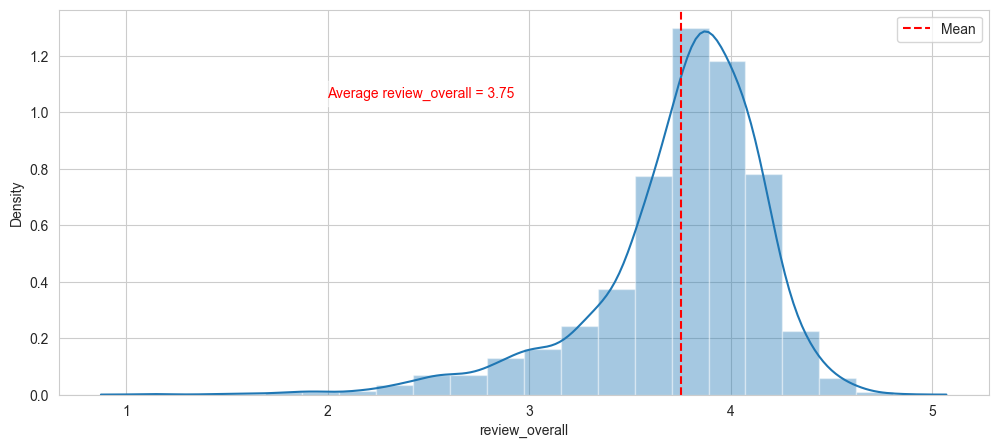

In [46]:
plot_attribute_density(ds, 'review_overall')

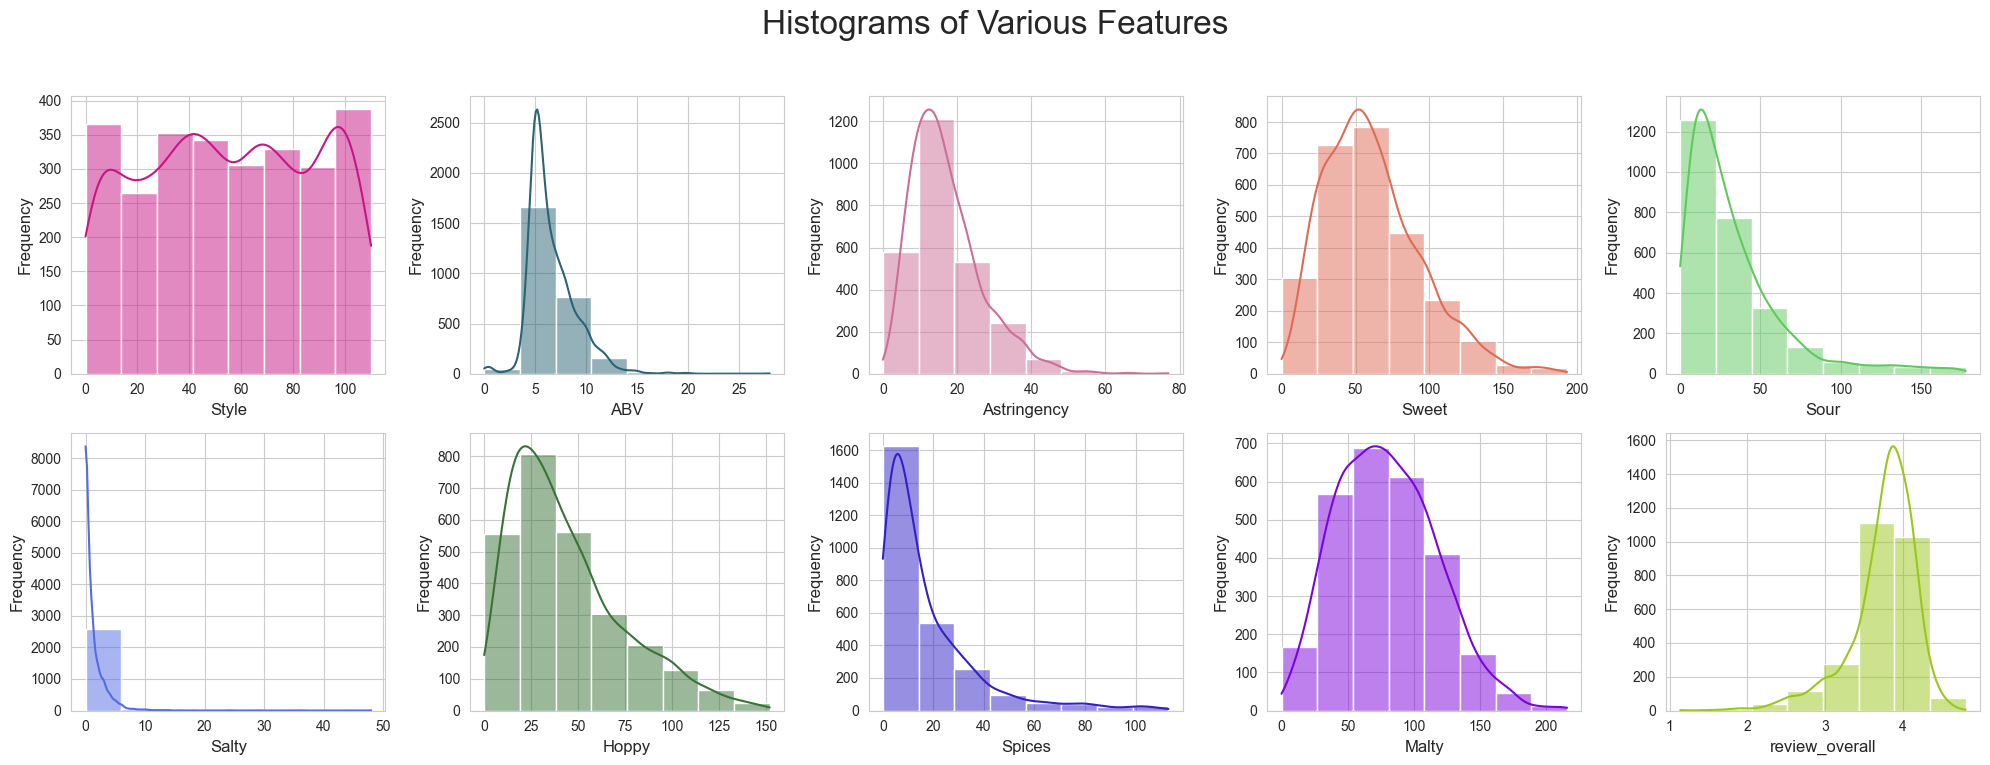

In [48]:
plot_attrs_frequency(ds, ds.columns)

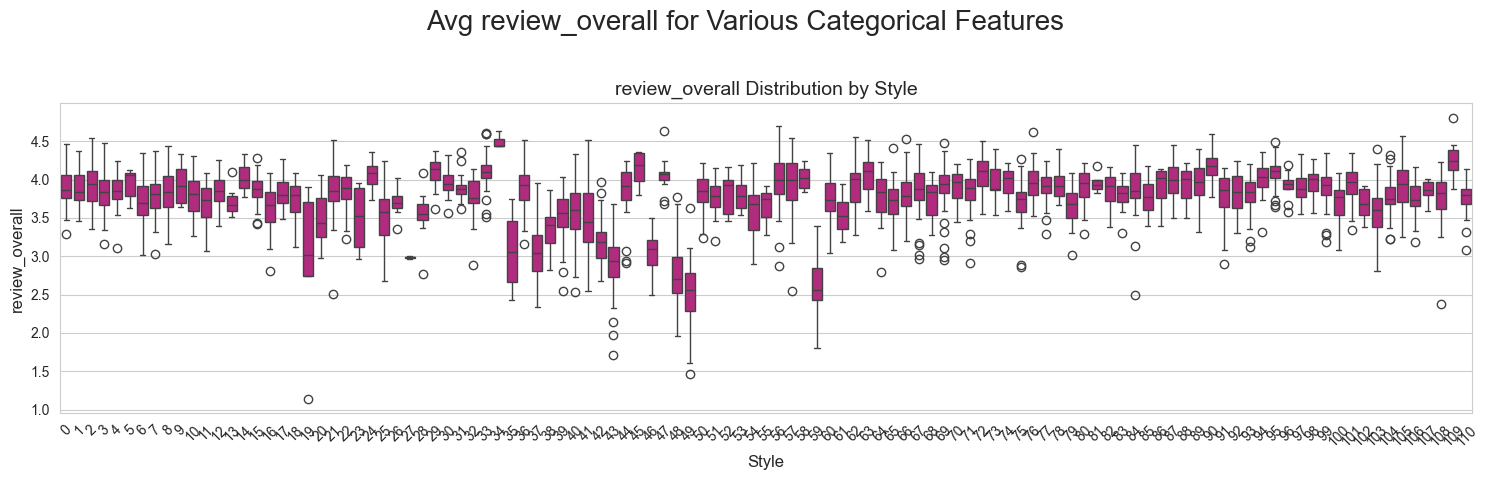

In [64]:
plot_attr_distr_by_catcols(ds, 'review_overall', ['Style'])

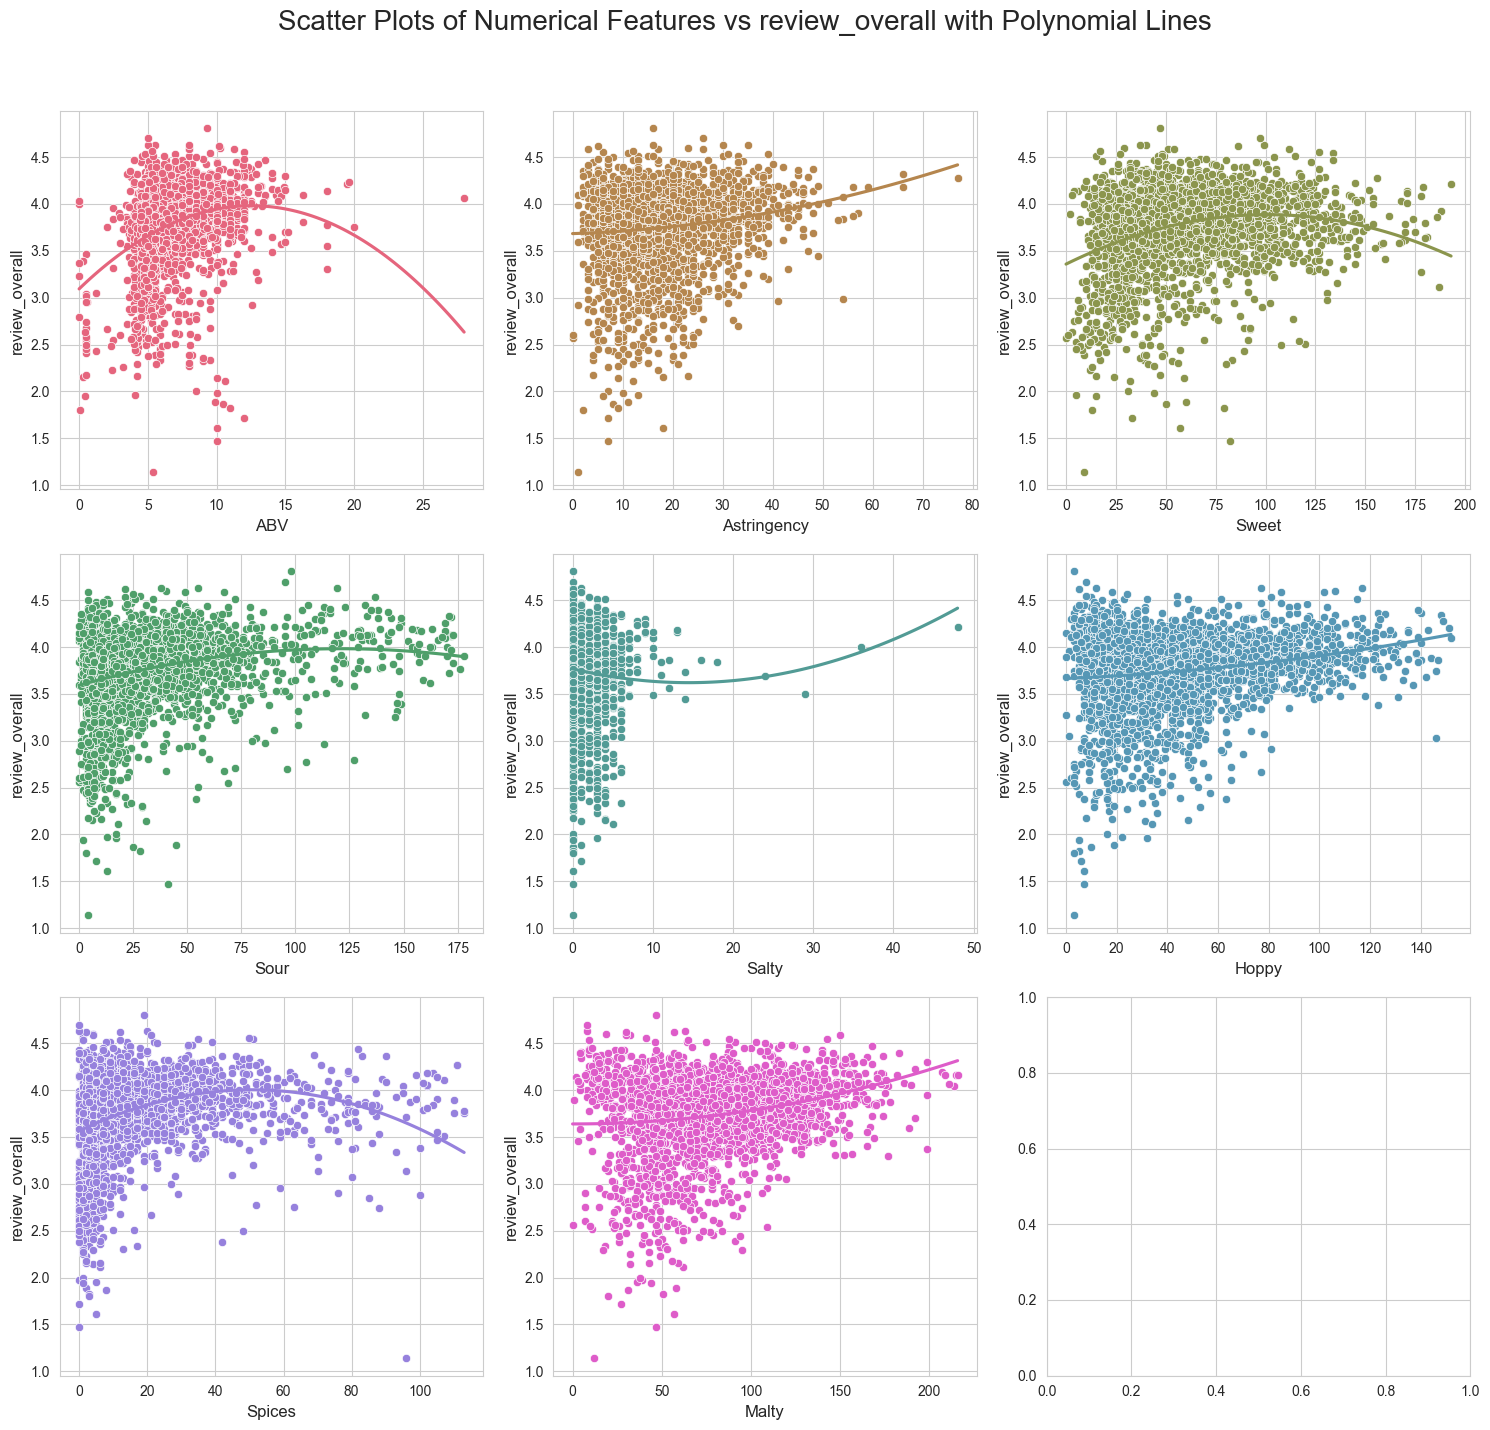

In [67]:
numerical_cols = ds.select_dtypes(include=['float64', 'int64']).columns
selected_cols = [col for col in numerical_cols if col not in ['review_overall']]
plot_attr_polym_line_vs_num_feature(ds, 'review_overall', selected_cols)

In [33]:
ds.describe(exclude='O')

,Style,ABV,Astringency,Sweet,Sour,Salty,Hoppy,Spices,Malty,review_overall
count,2731.000000,2731.000000,2731.000000,2731.000000,2731.000000,2731.000000,2731.000000,2731.000000,2731.000000,2731.000000
mean,55.880996,6.603841,17.268400,61.887221,34.890882,1.047602,43.396924,18.984255,79.175027,3.753779
std,32.636180,2.308537,10.189168,33.417249,36.000679,2.183338,30.287800,23.785891,37.844294,0.422604
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.136364
25%,29.000000,5.000000,10.000000,38.000000,12.000000,0.000000,20.000000,5.000000,50.000000,3.588132
50%,56.000000,6.000000,15.000000,57.000000,24.000000,0.000000,36.000000,11.000000,77.000000,3.833333
75%,84.000000,7.800000,22.000000,80.000000,44.000000,1.000000,59.000000,24.000000,105.000000,4.027778
max,110.000000,28.000000,81.000000,263.000000,284.000000,48.000000,172.000000,184.000000,239.000000,4.807692


In [34]:
outlier_columns = ['Sweet', 'Sour', 'Hoppy', 'Spices', 'Malty']

In [35]:
threshold = 4

In [36]:
ds_new = ds[(np.abs(stats.zscore(ds[outlier_columns])) < threshold).all(axis=1)]
ds_new.describe(exclude='O')

,Style,ABV,Astringency,Sweet,Sour,Salty,Hoppy,Spices,Malty,review_overall
count,2649.000000,2649.000000,2649.000000,2649.000000,2649.00000,2649.000000,2649.000000,2649.000000,2649.000000,2649.000000
mean,55.580974,6.591031,16.973952,61.388826,33.16912,1.037373,43.822952,17.327293,79.611174,3.751060
std,32.654391,2.318566,9.502011,32.464677,31.14263,2.189933,29.983983,19.148798,37.400338,0.424409
min,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,1.136364
25%,29.000000,5.000000,10.000000,37.000000,12.00000,0.000000,21.000000,5.000000,51.000000,3.586498
50%,54.000000,6.000000,15.000000,57.000000,24.00000,0.000000,36.000000,11.000000,77.000000,3.833333
75%,83.000000,7.800000,22.000000,80.000000,43.00000,1.000000,59.000000,23.000000,105.000000,4.026316
max,110.000000,28.000000,77.000000,193.000000,178.00000,48.000000,152.000000,113.000000,216.000000,4.807692


In [37]:
ds_new.shape

(2649, 10)

In [38]:
outlier_params = {  
    'columns': outlier_columns,  
    'threshold': threshold 
}  
save_outliers(outlier_params)  

In [39]:
ds = ds_new

<hr>

#### Standardisation

In [70]:
# set up the scaler
scaler = MinMaxScaler()
# Specify the columns to scale (all columns except 'class')  
columns_to_scale = [col for col in ds.columns if col != 'review_overall']  
columns_to_scale

['Style',
 'ABV',
 'Astringency',
 'Sweet',
 'Sour',
 'Salty',
 'Hoppy',
 'Spices',
 'Malty']

In [71]:
# Fit the scaler to the train set, it will learn the parameters  
scaler.fit(ds[columns_to_scale])  

MinMaxScaler()

In [72]:
save_scaler(scaler)

In [73]:
# Transform train and test sets  
ds_scaled = scaler.transform(ds[columns_to_scale]) 

In [74]:
# Create a new DataFrame with the scaled data  
df_scaled = pd.DataFrame(ds_scaled, columns=columns_to_scale)    

In [75]:
# Copy the 'class' column from the original DataFrame  
df_scaled['review_overall'] = ds['review_overall'].values  
ds = df_scaled
# Now df_scaled is a DataFrame with all columns scaled except 'class'  
np.round(ds.describe(), 1)

,Style,ABV,Astringency,Sweet,Sour,Salty,Hoppy,Spices,Malty,review_overall
count,2649.0,2649.0,2649.0,2649.0,2649.0,2649.0,2649.0,2649.0,2649.0,2649.0
mean,0.5,0.2,0.2,0.3,0.2,0.0,0.3,0.2,0.4,3.8
std,0.3,0.1,0.1,0.2,0.2,0.0,0.2,0.2,0.2,0.4
min,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.1
25%,0.3,0.2,0.1,0.2,0.1,0.0,0.1,0.0,0.2,3.6
50%,0.5,0.2,0.2,0.3,0.1,0.0,0.2,0.1,0.4,3.8
75%,0.8,0.3,0.3,0.4,0.2,0.0,0.4,0.2,0.5,4.0
max,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,4.8


<hr>

# Modelling

In [108]:
import time
from sklearn.linear_model import LinearRegression
from lightgbm import LGBMRegressor
from sklearn.linear_model import SGDRegressor
from sklearn.linear_model import ElasticNet
from sklearn.linear_model import BayesianRidge
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import Ridge, Lasso
from sklearn.neighbors import KNeighborsRegressor
import xgboost as xgb
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from catboost import CatBoostRegressor

In [104]:
# Let's predict  stem height
y_column = ds.columns[-1]
X_columns = ds.columns[:-1]

print("Target variable: " + str(y_column))
print("Features: " + str(X_columns))

Target variable: review_overall
Features: Index(['Style', 'ABV', 'Astringency', 'Sweet', 'Sour', 'Salty', 'Hoppy',
       'Spices', 'Malty'],
      dtype='object')


In [105]:
X = ds[X_columns]
y = ds[y_column]

In [106]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=30)

In [111]:
models = [ LinearRegression(), 
           LGBMRegressor(),
           SGDRegressor(),
           RandomForestRegressor(),
           ElasticNet(),
           BayesianRidge(),
           GradientBoostingRegressor(),
           SVR(),
           DecisionTreeRegressor(),
           Ridge(random_state = 30), 
           Lasso(random_state = 30),
           KNeighborsRegressor(),
           RandomForestRegressor(random_state = 42),
           xgb.XGBRegressor(random_state = 42),
           DecisionTreeRegressor(random_state = 42),
           CatBoostRegressor()
]

#### Baseline scores

In [112]:
# Baseline scores (assuming the same prediction for all data samples)
rmse_bs_train = mean_squared_error(y_train, [np.mean(y_train)]*len(y_train), squared=False)
rmse_bs_test = mean_squared_error(y_test, [np.mean(y_train)]*len(y_test), squared=False)
print(f"RMSE baseline score for train {round(rmse_bs_train,3)}, and for test {round(rmse_bs_test,3)}")

RMSE baseline score for train 0.42, and for test 0.442


In [113]:
model = test_regression_models(X_train, y_train, X_test, y_test, models, metric=mean_squared_error)

print("\nBest estimated model: " + str(model))

<function mean_squared_error at 0x0000024135B6B9C0>

LinearRegression():
<function mean_squared_error at 0x0000024135B6B9C0>:
0.14747559071132318
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000199 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 913
[LightGBM] [Info] Number of data points in the train set: 2119, number of used features: 9
[LightGBM] [Info] Start training from score 3.753559
<function mean_squared_error at 0x0000024135B6B9C0>

LGBMRegressor():
<function mean_squared_error at 0x0000024135B6B9C0>:
0.09642963330437868
<function mean_squared_error at 0x0000024135B6B9C0>

SGDRegressor():
<function mean_squared_error at 0x0000024135B6B9C0>:
0.15611829844149608
<function mean_squared_error at 0x0000024135B6B9C0>

RandomForestRegressor():
<function mean_squared_error at 0x0000024135B6B9C0>:
0.09732486603345326
<function mean_squared_error at 0x0000024135B6B9C0>

ElasticNet():
<function me

<hr>

#### Feature importances

In [115]:
# we can use Random forest classifier
importances = model.feature_importances_
indices = np.argsort(importances)[::-1]

# Print the feature ranking
print("Feature ranking:")
for f in range(X_train.shape[1]):
    print("%d. %s (%f)" % (f + 1, X_columns[indices[f]], importances[indices[f]]))

Feature ranking:
1. Style (24.225967)
2. ABV (12.594690)
3. Malty (11.724968)
4. Hoppy (11.706816)
5. Spices (11.429454)
6. Sour (9.591013)
7. Astringency (7.903782)
8. Sweet (7.277031)
9. Salty (3.546278)


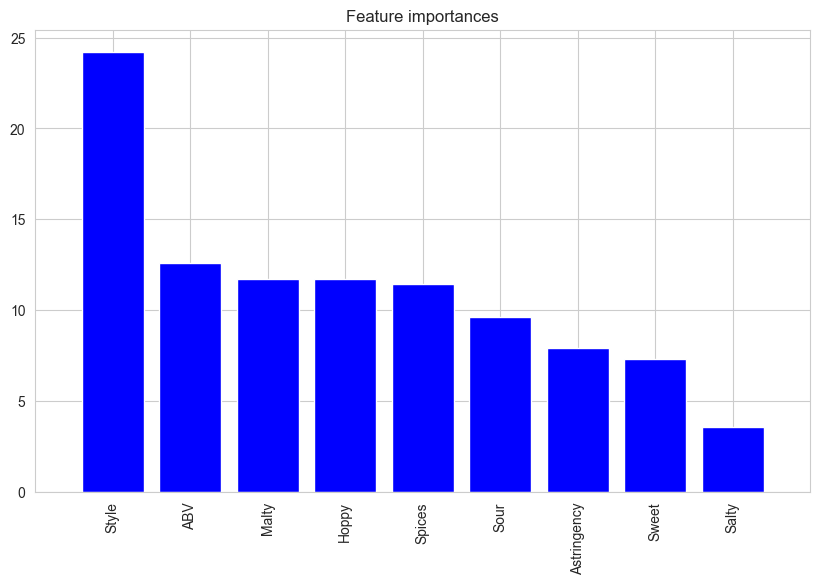

In [118]:
plot_feature_importances(model, X_columns)

Permutation importance is a technique used in machine learning to measure the feature importance. It helps to understand the contribution of each feature towards the predictive power of a model.

The concept is simple:
- Train a model.
- Shuffle the values in a single column (i.e., a feature), making this column no longer meaningful.
- Measure how much the model's performance decreases after the shuffling.

The idea is that the importance of a feature is determined by how much the model's performance decreases when the feature's information is destroyed

In [120]:
imps = permutation_importance(model, X_test, y_test)
importances = imps.importances_mean
std = imps.importances_std
indices = np.argsort(importances)[::-1]

# Print the feature ranking
print("Feature ranking:")
for f in range(X_train.shape[1]):
    print("%d. %s (%f)" % (f + 1, X_columns[indices[f]], importances[indices[f]]))

Feature ranking:
1. Style (0.263572)
2. Hoppy (0.117076)
3. Malty (0.109233)
4. ABV (0.100859)
5. Spices (0.090134)
6. Sour (0.051240)
7. Astringency (0.050320)
8. Sweet (0.041194)
9. Salty (0.004932)


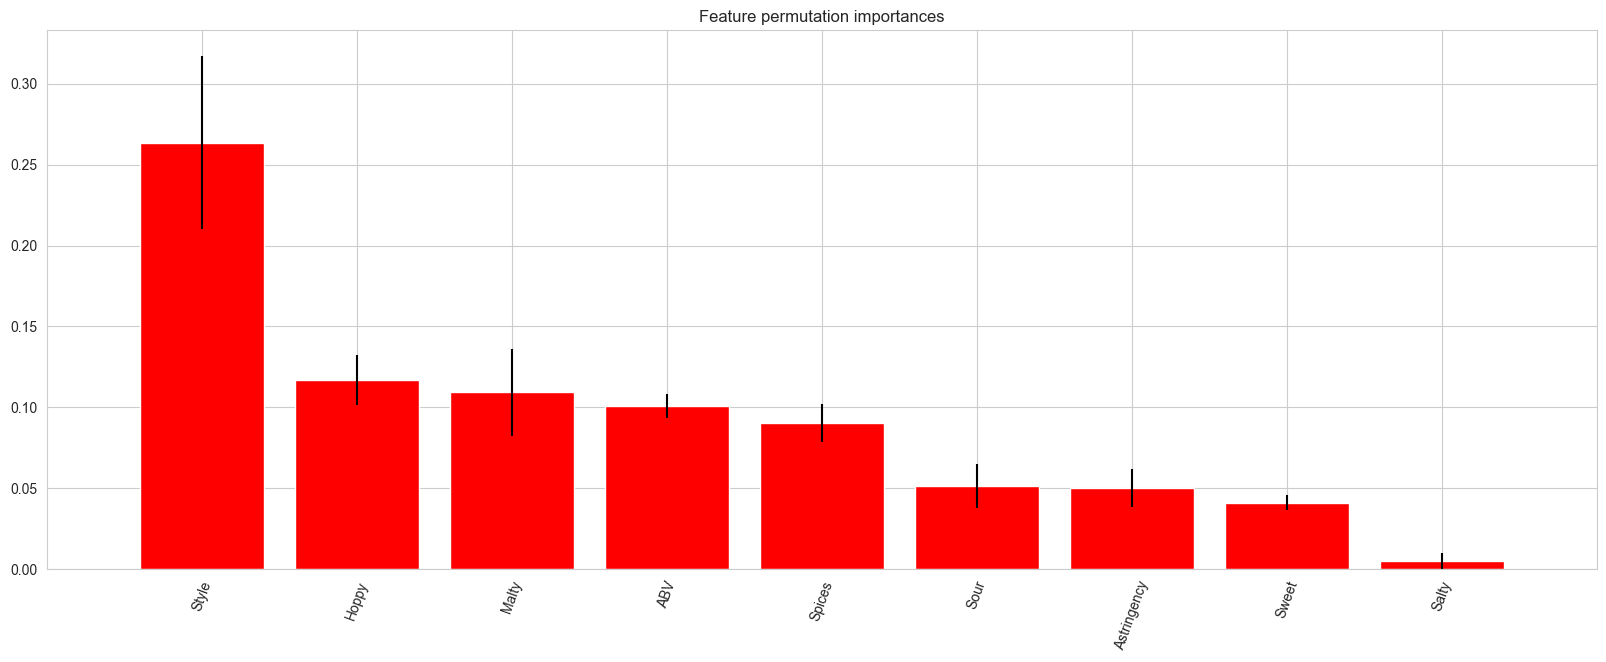

In [122]:
plot_permutation_importances(X_columns, importances, X_train, indices, std)

### Train-Valid-Test Split

In [123]:
y_column = ds.columns[-1]
X_columns = ds.columns[:-1]

print("Target variable: " + str(y_column))
print("Features: " + str(X_columns))

Target variable: review_overall
Features: Index(['Style', 'ABV', 'Astringency', 'Sweet', 'Sour', 'Salty', 'Hoppy',
       'Spices', 'Malty'],
      dtype='object')


<hr>

#### Random permutations cross-validation
The ShuffleSplit iterator will generate a user defined number of independent train / test dataset splits. Samples are first shuffled and then split into a pair of train and test sets.

It is possible to control the randomness for reproducibility of the results by explicitly seeding the random_state pseudo random number generator.




In [134]:
# Shuffles and splits the data  
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=30)  
  
regressor = CatBoostRegressor()  
regressor.fit(X_train, y_train)  
y_pred = regressor.predict(X_test)  
print('Train/Test split MSE metric: \n', metrics.mean_squared_error(y_test, y_pred))  

Learning rate set to 0.046101
0:	learn: 0.4127087	total: 2.08ms	remaining: 2.08s
1:	learn: 0.4069042	total: 3.7ms	remaining: 1.85s
2:	learn: 0.4010585	total: 5.3ms	remaining: 1.76s
3:	learn: 0.3965603	total: 7.09ms	remaining: 1.76s
4:	learn: 0.3917539	total: 8.98ms	remaining: 1.79s
5:	learn: 0.3867741	total: 10.9ms	remaining: 1.81s
6:	learn: 0.3817167	total: 12.6ms	remaining: 1.78s
7:	learn: 0.3763283	total: 14.1ms	remaining: 1.75s
8:	learn: 0.3713308	total: 15.5ms	remaining: 1.7s
9:	learn: 0.3668731	total: 16.7ms	remaining: 1.66s
10:	learn: 0.3634069	total: 18.1ms	remaining: 1.63s
11:	learn: 0.3593317	total: 19.5ms	remaining: 1.6s
12:	learn: 0.3562770	total: 20.9ms	remaining: 1.58s
13:	learn: 0.3531250	total: 22.2ms	remaining: 1.56s
14:	learn: 0.3501547	total: 23.5ms	remaining: 1.54s
15:	learn: 0.3479092	total: 24.7ms	remaining: 1.52s
16:	learn: 0.3451759	total: 26ms	remaining: 1.5s
17:	learn: 0.3424074	total: 27.4ms	remaining: 1.5s
18:	learn: 0.3397589	total: 28.9ms	remaining: 1.49s


In [132]:
from sklearn.model_selection import ShuffleSplit

ss = ShuffleSplit(n_splits=1, test_size=0.2, random_state=0)
train_index, test_index = next(ss.split(X))
regressor = CatBoostRegressor()
regressor.fit(X.iloc[train_index], y.iloc[train_index])
y_pred = regressor.predict(X.iloc[test_index])
print('ShuffleSplit set MSE metric: \n', metrics.mean_squared_error(y.iloc[test_index], y_pred))

<hr>

#### Hyperparameter Tuning
Now we will be performing the tuning of hyperparameters of the CatBoostRegressor model. 


In [141]:
from sklearn.model_selection import RandomizedSearchCV  
from catboost import CatBoostRegressor  
  
# Define the hyperparameter configuration space  
params = {  
    'depth': [3, 4, 5, 6, 7, 8, 9, 10],  
    'learning_rate': [0.01, 0.03, 0.05, 0.1, 0.15, 0.2],  
    'iterations': [100, 200, 300, 400, 500, 600, 700, 800, 900, 1000],  
    'l2_leaf_reg': [0.5, 1, 2, 3, 5, 7, 9, 11, 13, 15],  
    'border_count': [32, 64, 128, 254],  
    'thread_count': [4],  
} 
  
# Initialize the CatBoost Regressor  
regressor = CatBoostRegressor()  
  
# Initialize the Random Search  
random_search = RandomizedSearchCV(estimator=regressor, param_distributions=params, cv=5, n_jobs=-1,return_train_score=True)  
  
# Fit the random search model  
random_search.fit(X, y)  
  
# Print The value of best hyperparameters  
print("\nThe best parameters are %s with a score of %0.2f"
      % (random_search.best_params_, random_search.best_score_))

0:	learn: 0.4225901	total: 2.2ms	remaining: 1.54s
1:	learn: 0.4210419	total: 4.93ms	remaining: 1.72s
2:	learn: 0.4191915	total: 6.73ms	remaining: 1.56s
3:	learn: 0.4174403	total: 8.47ms	remaining: 1.47s
4:	learn: 0.4158807	total: 10.3ms	remaining: 1.43s
5:	learn: 0.4140642	total: 12.1ms	remaining: 1.4s
6:	learn: 0.4125779	total: 13.8ms	remaining: 1.37s
7:	learn: 0.4111588	total: 15.9ms	remaining: 1.37s
8:	learn: 0.4094941	total: 17.6ms	remaining: 1.35s
9:	learn: 0.4081164	total: 19.7ms	remaining: 1.36s
10:	learn: 0.4064424	total: 21.5ms	remaining: 1.35s
11:	learn: 0.4049917	total: 23.3ms	remaining: 1.33s
12:	learn: 0.4035186	total: 25.1ms	remaining: 1.33s
13:	learn: 0.4021302	total: 27ms	remaining: 1.32s
14:	learn: 0.4006061	total: 28.8ms	remaining: 1.32s
15:	learn: 0.3990956	total: 30.6ms	remaining: 1.31s
16:	learn: 0.3975718	total: 32.5ms	remaining: 1.3s
17:	learn: 0.3962077	total: 34.2ms	remaining: 1.3s
18:	learn: 0.3948580	total: 36.1ms	remaining: 1.29s
19:	learn: 0.3933292	total: 

In [142]:
regressor = CatBoostRegressor(thread_count= 4, border_count= 64, learning_rate= 0.01, l2_leaf_reg= 1, iterations=700, depth= 8)
regressor.fit(X.iloc[train_index], y.iloc[train_index])
y_pred = regressor.predict(X.iloc[test_index])
print('Final MSE metric: \n', metrics.mean_squared_error(y.iloc[test_index], y_pred))

0:	learn: 0.4239342	total: 13.6ms	remaining: 9.51s
1:	learn: 0.4223917	total: 15.8ms	remaining: 5.53s
2:	learn: 0.4205021	total: 17.8ms	remaining: 4.13s
3:	learn: 0.4187660	total: 19.6ms	remaining: 3.41s
4:	learn: 0.4171786	total: 21.7ms	remaining: 3.01s
5:	learn: 0.4157413	total: 23.7ms	remaining: 2.74s
6:	learn: 0.4142308	total: 25.8ms	remaining: 2.55s
7:	learn: 0.4127587	total: 28.1ms	remaining: 2.43s
8:	learn: 0.4110428	total: 30.2ms	remaining: 2.32s
9:	learn: 0.4094765	total: 32.4ms	remaining: 2.23s
10:	learn: 0.4080314	total: 34.2ms	remaining: 2.14s
11:	learn: 0.4064848	total: 36.2ms	remaining: 2.08s
12:	learn: 0.4049406	total: 38.5ms	remaining: 2.03s
13:	learn: 0.4035630	total: 40.6ms	remaining: 1.99s
14:	learn: 0.4020151	total: 43ms	remaining: 1.96s
15:	learn: 0.4005476	total: 45.2ms	remaining: 1.93s
16:	learn: 0.3992185	total: 47.4ms	remaining: 1.9s
17:	learn: 0.3980407	total: 49.7ms	remaining: 1.88s
18:	learn: 0.3966536	total: 51.8ms	remaining: 1.86s
19:	learn: 0.3951846	tota